# Exercise for Dominate set Problem

In [5]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from typing import Any, Dict, List, Tuple
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

## Define special class for drawing graphs 

(Nothing to do here)

In [161]:
# Firstly, we define a class we can draw a graph in convinient way
class GraphModel:
    
    n_qubits: int
    edges: List[Tuple[int, int]]
    graph: nx.Graph
          
    def __init__(self, n_qubits, edges, qaoa_solve=None):
        
        self.n_qubits = n_qubits
        self.edges = edges
        self.graph = nx.Graph()
        self.graph.add_nodes_from(np.arange(0,n_qubits,1))
        self.graph.add_edges_from(edges)
        #self.qaoa_solve = qaoa_solve
        
    def draw_raw_graph(self):
        
        # Generate plot of the  Graph
        colors       = ['hotpink' for node in self.graph.nodes()]
        default_axes = plt.axes(frameon=False)
        random_pos = nx.random_layout(self.graph, seed=42)
        pos = nx.spring_layout(self.graph, pos=random_pos)

        nx.draw_networkx_nodes(self.graph, node_color=colors, node_size=1300,pos = pos, 
                    alpha=1, ax=default_axes)       
        nx.draw_networkx_edges(self.graph, pos = pos, width=8,alpha=1,ax=default_axes,
                               edge_color="tab:grey")
        nx.draw_networkx_labels(self.graph, pos = pos, font_size=22, font_color="whitesmoke")

    def draw_done_graph(self,bitstring):
        
        # Draw a graph in accordance with its bitstring
        color_map = []
        edgelist_different  = []
        edgelist_same  = []
        default_axes = plt.axes(frameon=False)
        default_axes.axis('off')
        random_pos = nx.random_layout(self.graph, seed=42)
        pos = nx.spring_layout(self.graph, pos=random_pos)
        
        if bitstring == None:
            self.draw_raw_graph()
        else:
            for i in bitstring:
                if i > 0:
                    color_map.append('blue')
                else: 
                    color_map.append('hotpink')
            for edge in self.edges:
                if bitstring[edge[0]] != bitstring[edge[1]]:
                    edgelist_different.append(edge)
                else:
                    edgelist_same.append(edge)
                    
            nx.draw_networkx_nodes(self.graph, node_color=color_map, node_size=1300,pos = pos, 
                    alpha=1, ax=default_axes)       
            nx.draw_networkx_edges(self.graph, pos = pos, edgelist = edgelist_same, 
                                   width=8,alpha=1,ax=default_axes,edge_color="tab:grey")
            nx.draw_networkx_edges(self.graph, pos = pos, edgelist = edgelist_different,
                                   width=8,alpha=1,ax=default_axes, edge_color="tab:red")
            nx.draw_networkx_labels(self.graph, pos = pos, font_size=22, font_color="whitesmoke")

In [163]:
def graph_drawing(G,regime, *args, **kwargs):
    bitstring = kwargs.get('bitstring', None)
    filename = kwargs.get('filename', None)
    figure, axes = plt.subplots(frameon=False)
    axes.axis('off')
    # Turn off tick labels
    req_dpi = 72  # ADDED
    figure.set_size_inches(1000 / float(req_dpi),  # MODIFIED
                           1000 / float(req_dpi)) 
    if regime == 'raw':
        G.draw_raw_graph()
    elif regime == 'done':
        G.draw_done_graph(bitstring)
    else:
        raise ValueError('Regime is wrong')
        
    figure.savefig(filename, format='png',
               transparent=True, dpi=req_dpi) 

### Here we can see how simle DSP problem on the Graph looks like

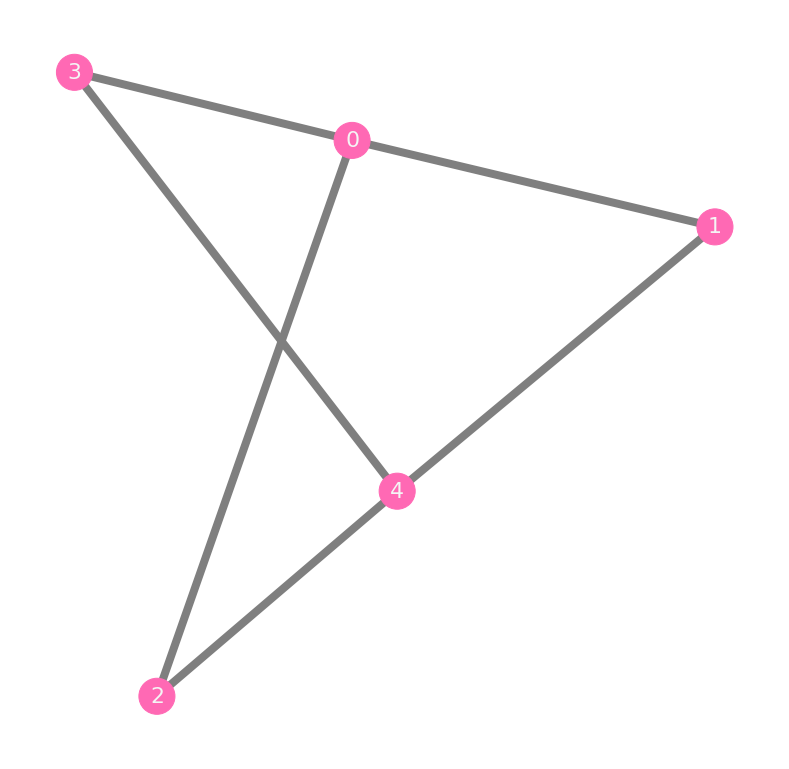

In [164]:
# Example of drawing method of the class GrapgModel
maxQubitNumber = 4
E = [(0,2) ,(0, 1),(0,3),(2,4),(3,4),(1,4)]
G = GraphModel(maxQubitNumber,E)
graph_drawing(G,'raw',filename = 'graph_model11.png')


### One of possible solitions can be easily found, for example

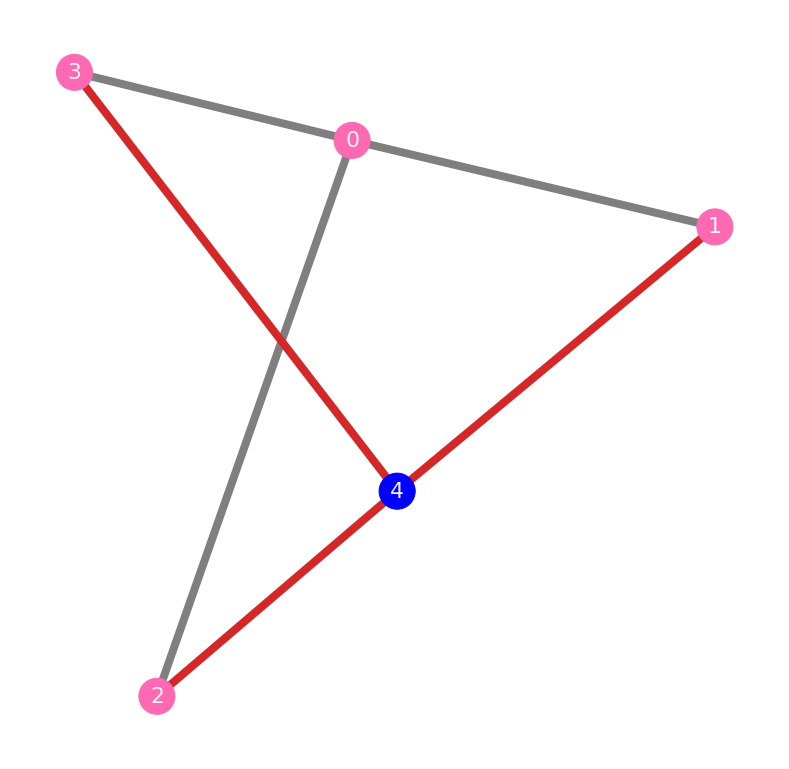

In [166]:
graph_drawing(G,'done',bitstring = [0,0,0,0,1],filename = 'graph_model22.png')

In [167]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.standard_gates import RZGate, MCXGate, MCPhaseGate, IGate
def addControlledOrRotation(gamma,size):
    sub_q = QuantumRegister(size)
    sub_circ = QuantumCircuit(sub_q, name='sub_circ')
    for i in range(3):
        sub_circ.crz(2*gamma,i,2)
        c3h_gate = RZGate(-2*gamma).control(2)
        sub_circ.append(c3h_gate, sub_q)
        sub_inst = sub_circ.to_instruction()
    return sub_inst

## Exercise1. Create a Contolled-Or Gates with rotation

The main challenge for QAOA problems on the graph is the process of constructing quantum circuit which corresponds to a certain cost function. In DSP problem controlled-or gate is used. We start with making this gate for 2 qubits which describe the graph and one auxiliary qubit. 

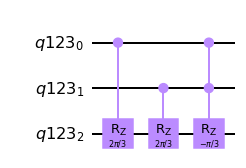

In [168]:
theta = np.pi /3
qr_cor2 = QuantumRegister(3)
cor2q = QuantumCircuit(qr_cor2,name='ControlledOr2')
# YOUR CODE HERE
gate = RZGate(-theta).control(2)
cor2q.crz(2*theta,0,2)
cor2q.crz(2*theta,1,2)
cor2q.append(gate, qr_cor2)
# YOUR CODE HERE
cor2q.draw("mpl")

In [131]:
def controlledOrRotation2(gamma):
    qr_cor2 = QuantumRegister(3)
    cor2q = QuantumCircuit(qr_cor2,name='ControlledOr2')
    # YOUR CODE HERE
    gate = RZGate(-2*gamma).control(2)
    cor2q.crz(2*gamma,0,2)
    cor2q.crz(2*gamma,1,2)
    cor2q.append(gate, qr_cor2)
     # YOUR CODE HERE
    sub_inst = cor2q.to_instruction()
    return sub_inst

## Exercise2. Toy Model

Here we create the simplest model possible. To illustrate the process we go through all the procedure of creating QAOA model for the following toy graph.

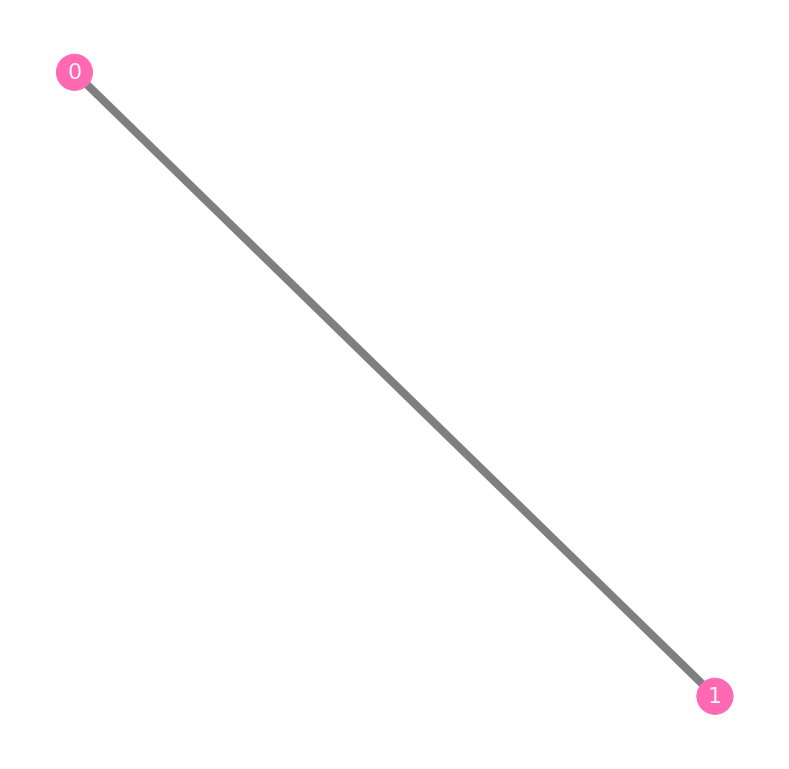

In [169]:
maxQubitNumber = 2
E = [(0, 1)]
G = GraphModel(maxQubitNumber,E)
graph_drawing(G,'raw',filename = 'graph_model11.png')

We ask you to finish the QAOA circuit for the Toy Model

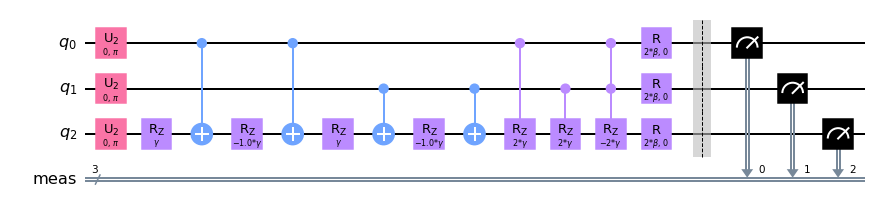

In [133]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

nqubits = 3
E = [(0, 1)]
G = GraphModel(nqubits,E)
# Drawing the circuit for p=1
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)

#YOU CODE HERE
for node in range(nqubits-1):
    qc_p.crz(2 * gamma,node,nqubits-1)
#YOU CODE HERE

qc_p.append(controlledOrRotation2(gamma),[0,1,2])
   

qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)

qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.measure_all()
qc_qaoa.decompose().decompose().draw("mpl")

In [149]:
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

## Exercise 3. Construction of cost function

We ask students here to create T and D function for the cost function 

In [150]:
def T(k,z): # just for our toy example
    # YOU CODE HERE
    answer = 0
    if k == 0 and z[1] == 1:
        answer +=1
    if k == 1 and z[0] == 1:
        answer +=1
        # YOU CODE HERE
    return answer

def D(k,z):
    # YOU CODE HERE
    answer = 0 
    if z[k]== 0:
        answer+=1
        
    # YOU CODE HERE
    return answer

In [155]:
def dsp_obj(x, G):

    obj = 0
    sol = list(int(i) for i in x)
    for j in sol:
        obj+= T(j,sol) + D(j,sol)
    return obj


def compute_expectation(counts, G):

    """
    Computes expectation value based on measurement results

    Args:
        counts: dict
                key as bitstring, val as count

        G: networkx graph

    Returns:
        avg: float
             expectation value
    """

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():

        obj = dsp_obj(bitstring, G)
        avg += obj * count
        sum_count += count

    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):

#     """
#     Creates a parametrized qaoa circuit

#     Args:  
#         G: networkx graph
#         theta: list
#                unitary parameters

#     Returns:
#         qc: qiskit circuit
#     """

    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)

    beta = theta[:p]
    gamma = theta[p:]

    # initial_state
    for i in range(0, nqubits):
        qc.h(i)

    for irep in range(0, p):

        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

    qc.measure_all()

    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=512):

#         """
#         Runs parametrized circuit

#         Args:
#             G: networkx graph
#             p: int,
#                Number of repetitions of unitaries
#         """

    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):

        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()

        return compute_expectation(counts, G)

    return execute_circ

def optimization(G,initial_parameters):
    expectation = get_expectation(G)

    res = minimize(expectation, initial_parameters, method='COBYLA')

    return res

In [156]:
qubits = 3
E = [(0, 1)]
G_model = GraphModel(2,E)
G = G_model.graph

In [157]:
p = 1
initial_parameters = [1.0,1.0]*p
model = QAOA(G,initial_parameters)
counts = model.counts

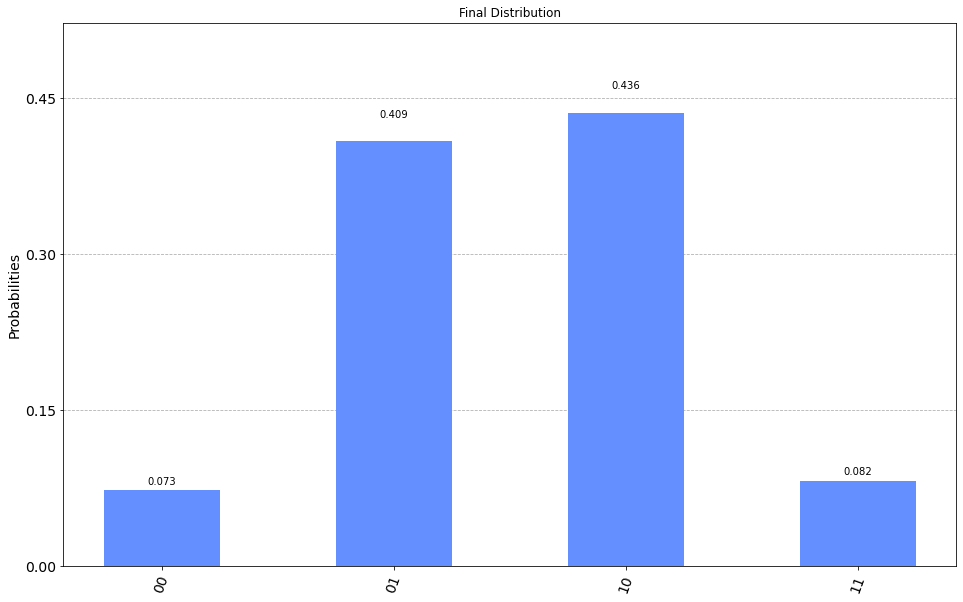

In [170]:
plot_histogram(model.counts, figsize=(16, 10), color=None, number_to_keep=None,
               sort='asc', target_string=None, legend=None,
               bar_labels=True, title="Final Distribution", ax=None)

In [135]:
class QAOA:
    counts: dict
    def __init__(self, graph, initial_parameters):
        self.graph = graph
        self.initial_parameters = initial_parameters
        
        backend = Aer.get_backend('aer_simulator')
        backend.shots = 512
        qc_res = create_qaoa_circ(graph, optimization(graph,initial_parameters).x)
        counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
        self.counts = counts
    
    def result(self):
        pass

In [159]:
p = 1
initial_parameters = [1.0,1.0]*p
model = QAOA(G,initial_parameters)
counts = model.counts

# Draft

In [ ]:
qreg = QuantumRegister(4) 
creg = ClassicalRegister(4)
qc = QuantumCircuit(qreg, creg)


control1 =  XGate().control(3, None, '110') #: old-style multy-controlled qubits
#control1 = MCXGate(3, None, '110') # fashion-style multi-controlled qubits

control2 = SwapGate().control(2, None, '10')

In [46]:
# gamma = Parameter("$\\gamma$")
# qc_p = QuantumCircuit(nqubits)
# E is supposed to be G.edges
l={}
aux_str = '0'+str(nqubits)+'b'
n = maxQubitNumber
for k in range(n):
    l[str(k)] = []
    for pair in E:  # pairs of nodes
        if pair[0] == k:  
            l[str(k)].append(pair[1])
        elif pair[1] == k:  
            l[str(k)].append(pair[0])
for key in l.keys():
    aux_element = []
    l[key] = list(map(lambda x: format(x,aux_str),l[key]))
    for j in range(len(l[key])):
        if l[key][j]!='0'*n:
            aux_element.append(l[key][j])
    l[key] = aux_element
print(E)
l

[(0, 2), (0, 1), (0, 3), (2, 4), (3, 4), (1, 4)]


{'0': ['0010', '0001', '0011'], '1': ['0100'], '2': ['0100'], '3': ['0100']}

In [115]:
from qiskit.quantum_info import Operator
from qiskit.circuit import QuantumCircuit
gate = Operator([[np.exp(-1j*theta),0],[0,1]]).to_instruction()
gate.label = "MyLabel"
cgate = gate.control()
circuit = QuantumCircuit(2)
circuit.append(cgate, [0, 1])
circuit.crz(theta,0,1)
circuit.draw()

q_0: ─────■──────────■─────
     ┌────┴────┐┌────┴────┐
q_1: ┤ MyLabel ├┤ Rz(π/3) ├
     └─────────┘└─────────┘

In [65]:
n

4

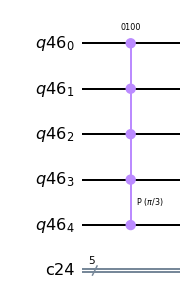

In [80]:
qreg = QuantumRegister(maxQubitNumber+1) 
creg = ClassicalRegister(maxQubitNumber+1)
qc = QuantumCircuit(qreg, creg)
control = MCPhaseGate(np.pi/3, 4,'0100')
qc.append(control, [0, 1, 2, 3, 4])
# for key in l.keys():
#     for condition in l[key]:
#         control = MCXGate(n, None, condition) # fashion-style multi-controlled qubits
#         qc.append(control, [0, 1, 2, 3, 4])
qc.draw("mpl")  

In [64]:
qreg = QuantumRegister(5) 
creg = ClassicalRegister(5)
qc = QuantumCircuit(qreg, creg)


control1 = MCXGate(4, None, '1100') # fashion-style multi-controlled qubits


qc.append(control1, [0, 1, 2, 3,4])
qc.measure(qreg,creg)   

qc.draw()

┌─┐            
q19_0: ──o──┤M├────────────
         │  └╥┘┌─┐         
q19_1: ──o───╫─┤M├─────────
         │   ║ └╥┘┌─┐      
q19_2: ──■───╫──╫─┤M├──────
         │   ║  ║ └╥┘┌─┐   
q19_3: ──■───╫──╫──╫─┤M├───
       ┌─┴─┐ ║  ║  ║ └╥┘┌─┐
q19_4: ┤ X ├─╫──╫──╫──╫─┤M├
       └───┘ ║  ║  ║  ║ └╥┘
c17: 5/══════╩══╩══╩══╩══╩═
             0  1  2  3  4

In [ ]:
gamma = np.pi/3
qc_p = QuantumCircuit(nqubits)


In [36]:
for key in l.keys():
    print(l[key])

[2, 1, 3]
[0, 4]
[0, 4]
[0, 4]


In [27]:
list(range(5))

[0, 1, 2, 3, 4]

In [29]:
ints = [1,2,3]
string_ints = [str(int) for int in ints]

str_of_ints = ",".join(string_ints)

print(str_of_ints)

1,2,3


In [34]:
aux_str = '0'+str(nqubits)+'b'
aux_str

'04b'

In [39]:
list(map(lambda x: format(x,aux_str),ints))

['0001', '0010', '0011']